In [1]:
%pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

import scipy.signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
from rtlsdr import RtlSdr

In [3]:
Fcarrier = 104.5e6
Foffset = 128e3
Fc = Fcarrier+Foffset # Center frequency
Fs = 1024000          # Sample rate

N = int(2 * Fs) # Pull in this many samples
gain = 38.6     # Gain

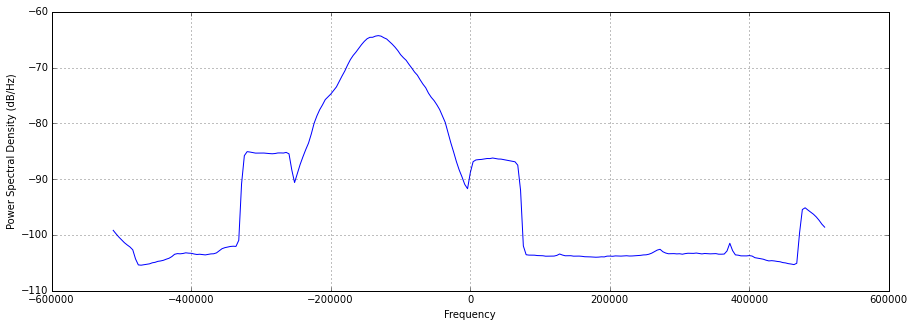

In [4]:
sdr = RtlSdr()
# configure device
sdr.sample_rate = int(Fs) # Hz
sdr.center_freq = int(Fc) # Hz
sdr.gain = gain

# Read samples
samples = sdr.read_samples(N)
sdr.close()
del(sdr)

psd(samples, Fs=Fs); None

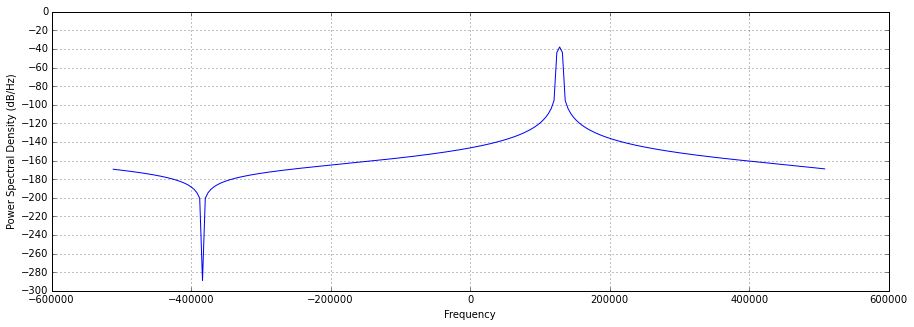

In [5]:
phase_vel = (2*np.pi*Foffset)/Fs
t = np.arange(0, len(samples), 1.0)
x_offset = np.cos(t*phase_vel) + 1.0j * np.sin(t*phase_vel)
psd(x_offset, Fs=Fs); None

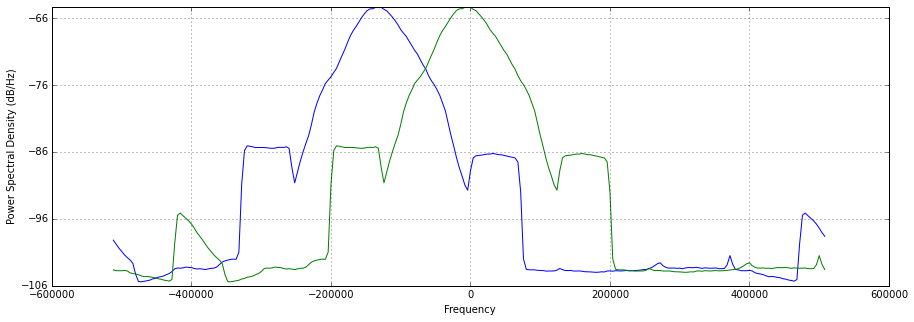

In [6]:
samples_shifted = samples * x_offset
psd(samples, Fs=Fs)
psd(samples_shifted, Fs=Fs)
None

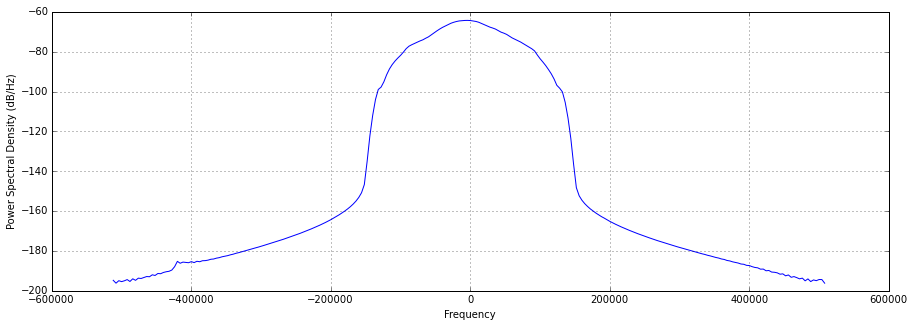

In [8]:
lpf_coeffs = scipy.signal.remez(111, [0, 100000, 150000, Fs/2], [1,0], Hz=Fs)

x = scipy.signal.lfilter(lpf_coeffs, 1.0, samples_shifted)
psd(x, Fs=Fs); None

In [9]:
def demod_pm(x, gain=1.0):
    xp = x[1:] * np.conj(x[:-1]) 
    retval = gain * np.arctan2(np.imag(xp), np.real(xp))
    return retval

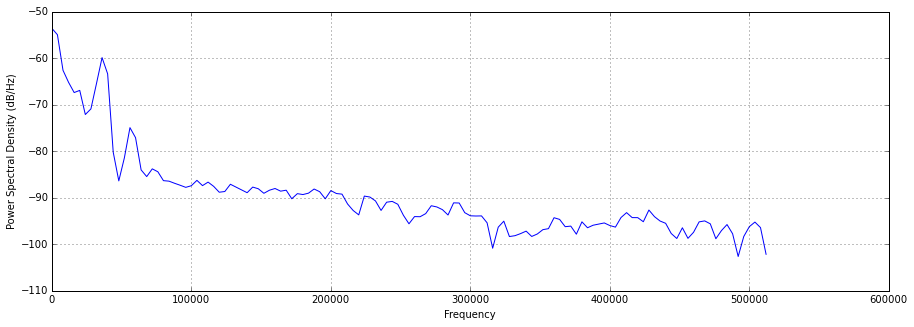

In [10]:
audio = demod_pm(x)
psd(audio, Fs=Fs); None

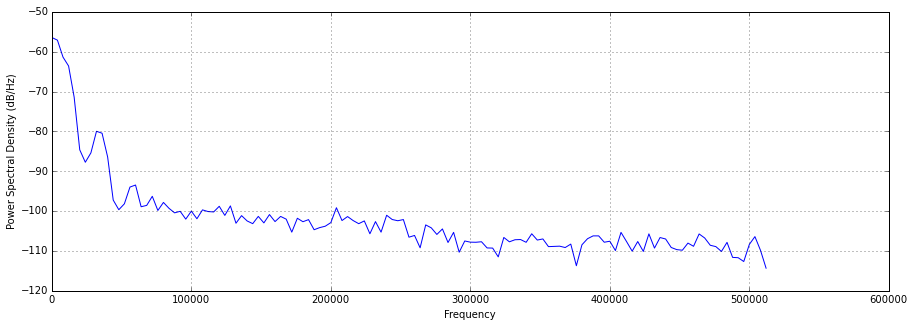

In [11]:
lpf_audio_coeffs = scipy.signal.remez(111, [0, 15000, 17000, Fs/2], [1,0], Hz=Fs)
audio_lpf = scipy.signal.lfilter(lpf_audio_coeffs, 1.0, audio)
psd(audio_lpf, Fs=Fs); None

44521

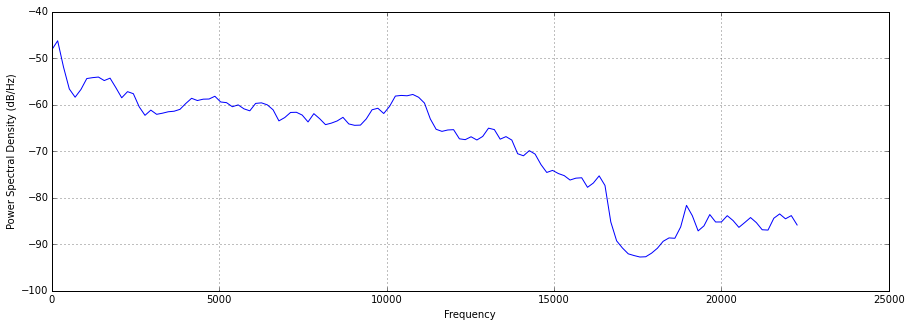

In [12]:
target_rate = 44100
downsample_ratio = int(Fs/target_rate)

Fa = Fs / downsample_ratio

audio_lpf_downsampled = audio_lpf[np.arange(0, len(audio), downsample_ratio)]

psd(audio_lpf_downsampled, Fs=Fa); Fa


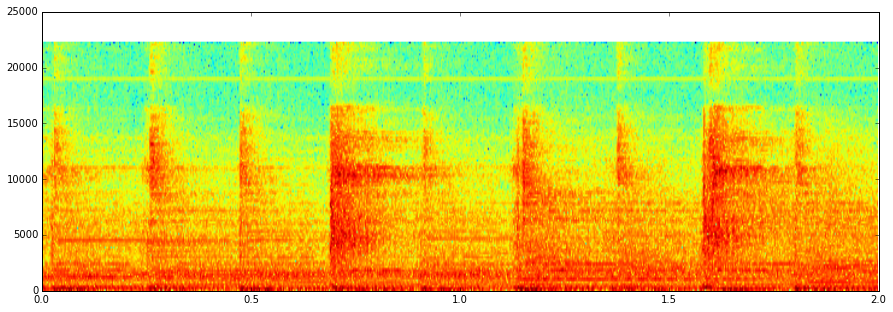

In [13]:
specgram(audio_lpf_downsampled, Fs=Fa); None

In [14]:
import scipy.io.wavfile

In [16]:
scipy.io.wavfile.write("foo2.wav", int(Fa), audio_lpf_downsampled)